<a href="https://colab.research.google.com/github/1boge/my_repos/blob/master/houses_afan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Потренируем навыки, полученные на практическом занятии. Пользуясь новыми знаниями, проведите эксплоративный анализ данных на данных недвижимости Бостона, и попытайтесь обучить линейную модель наиболее качественно. Все ваши действия и решения описывайте в markdown.


Данные вы сможете получить исполнив следующий код:

from sklearn.datasets import load_boston

import pandas as pd

data = pd.read_csv(load_boston()[‘filename’], skiprows=1)


Переменная, которую надо предсказать - ’MEDV’.
Прочитать информацию о содержимом датасета:
print(load_boston()[‘DESCR’])


Если вы неудовлетворенны результатом, но лучшего решения предложить не можете, то высылайте задание на проверку.


Цель задания - закрепить полученные навыки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
boston = load_boston()
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [3]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [4]:
df.shape

(506, 13)

Будем использовать линейную регрессию для тестирования качества данных

In [5]:
def get_score(X,y, random_seed=42, model=None):
  if model is None:
    model = LinearRegression()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed )  
  model.fit(X_train, y_train)
  return model.score(X_test, y_test)

Для поиска выбросов будем использовать boxplot

In [6]:
def get_boxplot(X, columns=[]):
  for i in columns:
    sns.boxplot(x=X[i])
  pass  

def get_pairplot(X, columns=None):
  if columns is None:
    columns = list(X.columns)
  sns.pairplot(X[columns])
  pass    

Для заполнения пропущенных значений будем использовать стандартные способы
- заполнение значением
- max
- min
- mode
- median
- mean
- метод индикатора
- линейная регрессия

In [7]:
def get_value(X, column, mode='mean', value=0, columns_for_reg=None):
  if mode == 'value':
    X.loc[X[X[column].isna()].index ,column] = value
  elif mode == 'max':
    X.loc[X[X[column].isna()].index ,column] = X[column].max()
  elif mode == 'min':
    X.loc[X[X[column].isna()].index ,column] = X[column].min()
  elif mode == 'median':
    X.loc[X[X[column].isna()].index ,column] = X[column].median()    
  elif mode == 'mode':
    X.loc[X[X[column].isna()].index, column] = X[column].mode()[0]  
  elif mode == 'indicator':
    X.loc[X[X[column].isna()].index, column] = 0
    X['ind_'+str(column)] = 0
    X.loc[X[X[column].isna()].index, 'ind_'+str(column)] = 1
  elif mode == 'linreg':
    if columns_for_reg is None:
      cols = list(X.select_dtypes([np.number]).columns) 
      cols.remove(column)
    else:
      cols = columns_for_reg
    X_tmp = X.dropna()  
    m = LinearRegression().fit(X_tmp[cols], X_tmp[column])
    X.loc[X[X[column].isna()].index, column] = m.predict(X[X[column].isna()][cols])
  else:
    X.loc[X[X[column].isna()].index, column] = X[column].mean()
  return X  


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


In [9]:
# Проверка на пропуски в данных
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [10]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


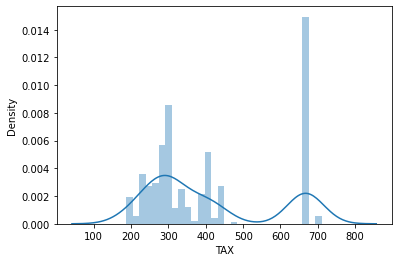

In [11]:
sns.distplot(df['TAX'], bins=30)
plt.show()

In [12]:
X = df.loc[:, df.columns != 'TAX']
y = df[['TAX']]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
linReg = LinearRegression()
linReg.fit(X_train, y_train)

LinearRegression()

In [15]:
predictions = linReg.predict(X_test)
linReg.score(X_test, y_test)

0.887966012089618

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


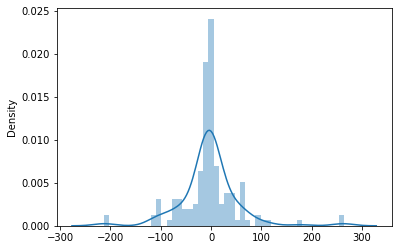

In [16]:
#Распределение ошибки
er = y_test - predictions
sns.distplot(er)

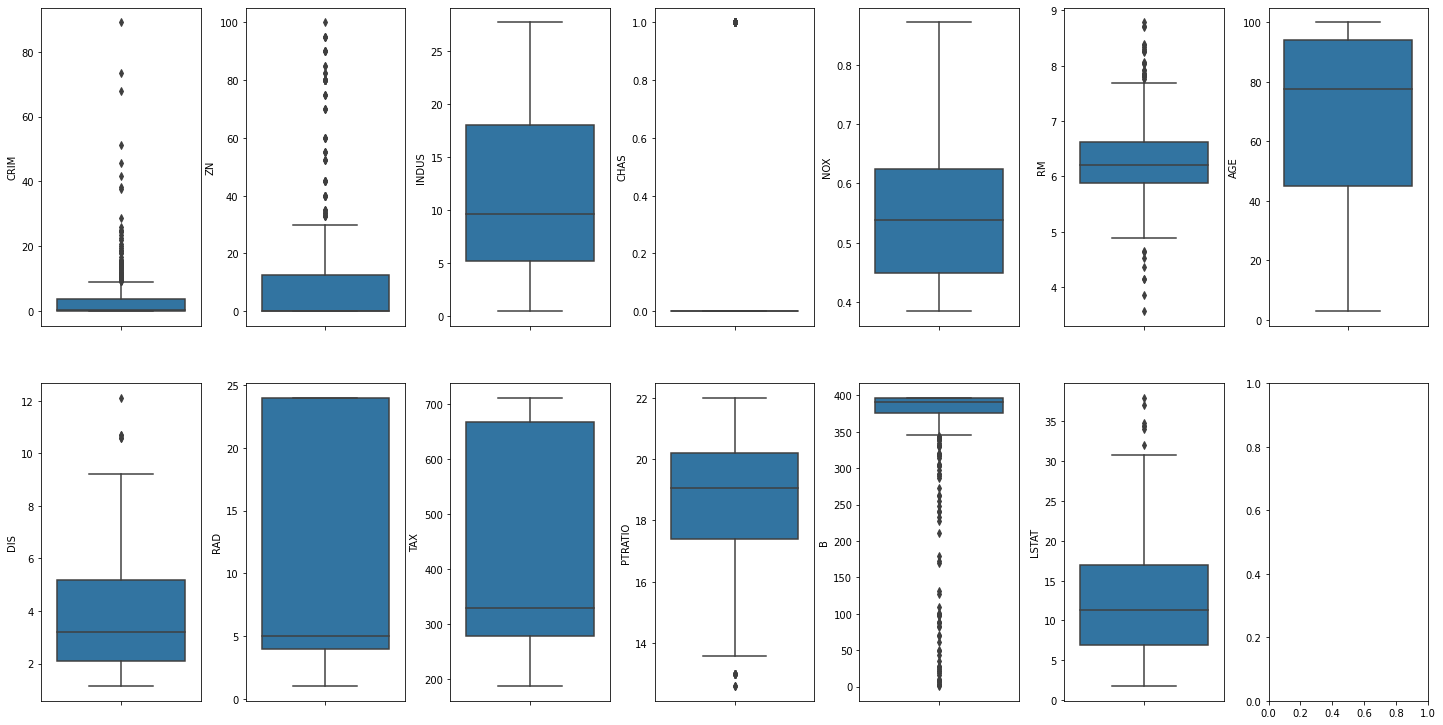

In [17]:
#Вылеты по признакам
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k, v in df.items():
    sns.boxplot(y=k, data=df, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

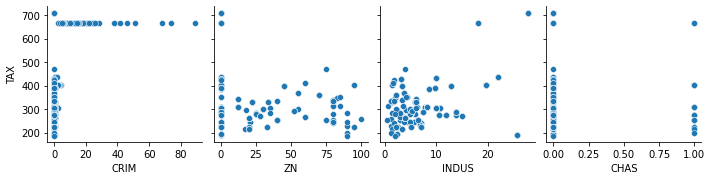

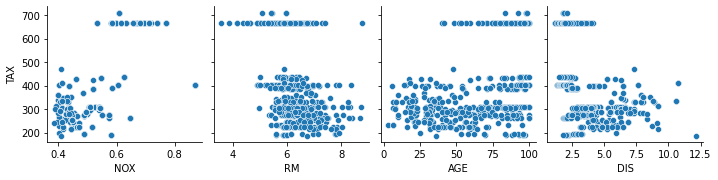

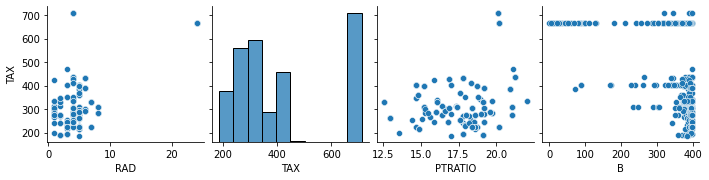

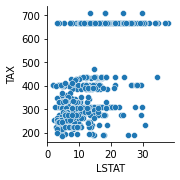

In [18]:
for i in range(0, len(df.columns), 4):
    sns.pairplot(data=df,
             x_vars=df.columns[i:i+4],
             y_vars=['TAX'])

In [19]:
for k, v in df.items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
    print("Column %s outliers = %.2f%%" % (k, perc))

Column CRIM outliers = 13.04%
Column ZN outliers = 13.44%
Column INDUS outliers = 0.00%
Column CHAS outliers = 100.00%
Column NOX outliers = 0.00%
Column RM outliers = 5.93%
Column AGE outliers = 0.00%
Column DIS outliers = 0.99%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 2.96%
Column B outliers = 15.22%
Column LSTAT outliers = 1.38%


In [20]:
#Удаление вылетов
df = df[~(df['TAX'] >= 600.0)]
df.shape

(369, 13)

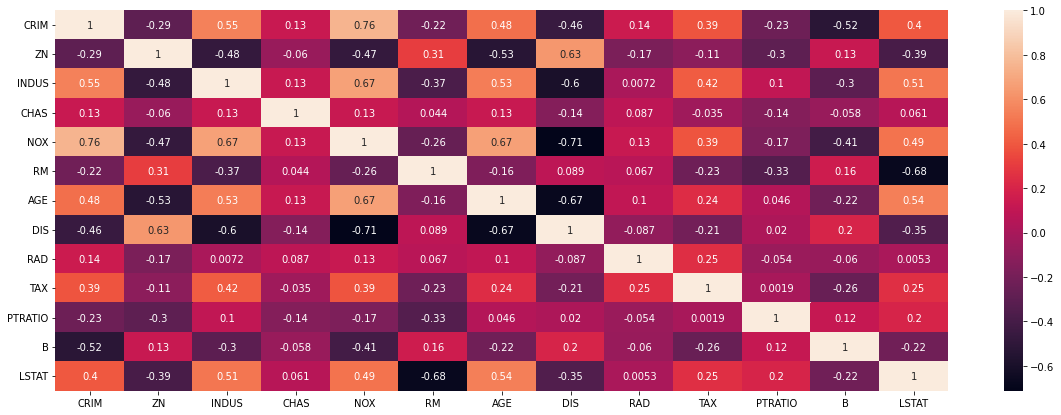

In [21]:
plt.figure(figsize=(20, 7))
sns.heatmap(data=df.corr(), annot=True)
plt.show()

In [22]:
# as we see we can try to predict 'MEDV' with 'LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE' features.
selected_cols = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'DIS', 'AGE','B']
X = df[selected_cols]
y = df[['TAX']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

linReg = LinearRegression()
linReg.fit(X_train, y_train)

predictions = linReg.predict(X_test)
linReg.score(X_test, y_test)

0.15324008636144792

In [23]:
#Можно попробовать применить скейлер
min_max_scaler = MinMaxScaler()
X_scaled = pd.DataFrame(data=min_max_scaler.fit_transform(X), columns=selected_cols)
X_scaled.head()

,LSTAT,INDUS,NOX,PTRATIO,RM,DIS,AGE,B
0,0.099449,0.073442,0.314815,0.287234,0.437467,0.256217,0.641607,1.000000
1,0.226744,0.262406,0.172840,0.553191,0.397174,0.337393,0.782698,1.000000
2,0.070379,0.262406,0.172840,0.553191,0.597070,0.337393,0.599382,0.987519
3,0.037026,0.068281,0.150206,0.648936,0.548142,0.438745,0.441813,0.993039
4,0.110159,0.068281,0.150206,0.648936,0.587127,0.438745,0.528321,1.000000


In [24]:
#Можно применить логарифмирование
y = np.log1p(y)
for col in X_scaled.columns:
    if np.abs(X_scaled[col].skew()) > 0.3:
        X_scaled[col] = np.log1p(X_scaled[col])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
linReg = LinearRegression()

linReg.fit(X_train, y_train)

predictions = linReg.predict(X_test)
linReg.score(X_test, y_test)

0.1365186892709801